In [1]:
import os
import unicodedata
import underthesea
import nltk
from tqdm import tqdm

In [2]:
def read_mt_dataset(type: str):
    # type : "train", "dev" or "test"
    folder_path = os.path.join("..", "data")
    en_file_path = os.path.join(folder_path, type, f"{type}.en")
    vi_file_path = os.path.join(folder_path, type, f"{type}.vi")
    with open(en_file_path, "r") as f:
        en_dataset = f.readlines()
        en_dataset = [line.strip() for line in en_dataset]
    with open(vi_file_path, "r") as f:
        vi_dataset = f.readlines()
        vi_dataset = [line.strip() for line in vi_dataset]
    return en_dataset, vi_dataset

In [3]:
train_en_sentences, train_vi_sentences = read_mt_dataset("train")
assert len(train_en_sentences) == len(train_vi_sentences)
print(f"train dataset: {len(train_en_sentences)}")

dev_en_sentences, dev_vi_sentences = read_mt_dataset("dev")
assert len(dev_en_sentences) == len(dev_vi_sentences)
print(f"dev dataset: {len(dev_en_sentences)}")

test_en_sentences, test_vi_sentences = read_mt_dataset("test")
assert len(test_en_sentences) == len(test_vi_sentences)
print(f"test dataset: {len(test_en_sentences)}")

train dataset: 2977999
dev dataset: 18719
test dataset: 19151


In [4]:
from abc import abstractmethod

class Tokenizer:
    def __init__(self, name):
        self.name = name
    
    @abstractmethod
    def tokenize(self, sentence: str) -> list[str]:
        pass

    def detokenize(self, words: list[str]) -> str:
        return " ".join(words)

In [5]:
# vietnamese tokenizer v1: word tokenization
class ViTokenizer(Tokenizer):
    def __init__(self):
        super().__init__("vietnamese")
    
    def tokenize(self, sentence: str) -> list[str]:
        sentence = unicodedata.normalize('NFC', sentence)
        sentence = underthesea.text_normalize(sentence)
        if len(sentence) == 0:
            return []
        return sentence.split(" ")
    
vi_tokenizer = ViTokenizer()
vi_tokenizer.tokenize("   Ðảm baỏ chất lựơng phòng  , thí nghịêm       hoá học")

['Đảm', 'bảo', 'chất', 'lượng', 'phòng', ',', 'thí', 'nghiệm', 'hóa', 'học']

In [6]:
# vietnamese tokenizer v2: multi-word tokenization
class ViTokenizerV2(Tokenizer):
    def __init__(self):
        super().__init__("vietnamese")
    
    def tokenize(self, sentence):
        sentence = unicodedata.normalize('NFC', sentence)
        sentence = underthesea.text_normalize(sentence)
        if len(sentence) == 0:
            return []
        return underthesea.word_tokenize(sentence)

vi_tokenizer_v2 = ViTokenizerV2()
vi_tokenizer_v2.tokenize("   Ðảm baỏ chất lựơng phòng  , thí nghịêm       hoá học")

['Đảm bảo', 'chất lượng', 'phòng', ',', 'thí nghiệm', 'hóa', 'học']

In [7]:
# english tokenizer
class EnTokenizer(Tokenizer):
    def __init__(self):
        super().__init__("english")

    def tokenize(self, sentence: str) -> list[str]:
        if len(sentence) == 0:
            return []
        return nltk.word_tokenize(sentence)
    
    def detokenize(self, tokens: list[str]) -> str:
        return " ".join(tokens)
    
en_tokenizer = EnTokenizer()
en_tokenizer.tokenize("Hello,     world!, I'm a student.")

['Hello', ',', 'world', '!', ',', 'I', "'m", 'a', 'student', '.']

In [8]:
train_en_sentences = [en_tokenizer.tokenize(sentence) for sentence in tqdm(train_en_sentences)]
dev_en_sentences = [en_tokenizer.tokenize(sentence) for sentence in tqdm(dev_en_sentences)]
test_en_sentences = [en_tokenizer.tokenize(sentence) for sentence in tqdm(test_en_sentences)]

100%|██████████| 19151/19151 [00:01<00:00, 15401.26it/s]


In [9]:
train_vi_sentences = [vi_tokenizer.tokenize(sentence) for sentence in tqdm(train_vi_sentences)]
dev_vi_sentences = [vi_tokenizer.tokenize(sentence) for sentence in tqdm(dev_vi_sentences)]
test_vi_sentences = [vi_tokenizer.tokenize(sentence) for sentence in tqdm(test_vi_sentences)]

100%|██████████| 19151/19151 [00:01<00:00, 9837.15it/s] 


In [10]:
class Vocabulary:
    UNK_TOKEN = "<UNK>"
    PAD_TOKEN = "<PAD>"
    SOS_TOKEN = "<SOS>"
    EOS_TOKEN = "<EOS>"

    def __init__(self, name: str, min_freq: int=2):
        self.name = name
        self.min_freq = min_freq
        self.word2idx = {
            Vocabulary.UNK_TOKEN: 0,
            Vocabulary.PAD_TOKEN: 1,
            Vocabulary.SOS_TOKEN: 2,
            Vocabulary.EOS_TOKEN: 3
        }
        self.word2count = {}
        self.idx2word = {
            0: Vocabulary.UNK_TOKEN,
            1: Vocabulary.PAD_TOKEN,
            2: Vocabulary.SOS_TOKEN,
            3: Vocabulary.EOS_TOKEN
        }
        self.n_words = 4  # Count SOS, EOS, PAD and UNK

    def add_sentence(self, words: list[str]):
        """
        words: danh sách các từ đã được tokenize
        """
        for word in words:
            self.add_word(word)

    def add_word(self, word: str):
        if word not in self.word2count:
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
        
        if word not in self.word2idx and self.word2count[word] >= self.min_freq:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.n_words += 1
    
    def word_to_index(self, word):
        if word in self.word2idx:
            return self.word2idx[word]
        else:
            return self.word2idx[Vocabulary.UNK_TOKEN]
        
    def sentence_to_index(self, words: list[str], max_len: int=0) -> list[int]:
        """
        words: danh sách các từ đã được tokenize
        """
        indexes = [self.word_to_index(Vocabulary.SOS_TOKEN)]
        indexes.extend(self.word_to_index(word) for word in words)
        indexes.append(self.word_to_index(Vocabulary.EOS_TOKEN))
        while len(indexes) < max_len:
            indexes.append(self.word_to_index(Vocabulary.PAD_TOKEN))
        return indexes
    
    def index_to_word(self, index: int):
        return self.idx2word[index]
    
    def indexes_to_sentence(self, indexes: list[int]) -> list[str]:
        return [self.idx2word[index] for index in indexes]

### Build English Vocab

In [11]:
en_vocab = Vocabulary("english", min_freq=40)

for sentence in tqdm(train_en_sentences):
    en_vocab.add_sentence(sentence)
print(f"total words: {len(en_vocab.word2count)}, total vocab: {en_vocab.n_words}")

for sentence in tqdm(dev_en_sentences):
    en_vocab.add_sentence(sentence)
print(f"total words: {len(en_vocab.word2count)}, total vocab: {en_vocab.n_words}")

for sentence in tqdm(test_en_sentences):
    en_vocab.add_sentence(sentence)
print(f"total words: {len(en_vocab.word2count)}, total vocab: {en_vocab.n_words}")

100%|██████████| 2977999/2977999 [00:15<00:00, 198269.82it/s]


total words: 421228, total vocab: 32739


100%|██████████| 18719/18719 [00:00<00:00, 213528.00it/s]


total words: 422712, total vocab: 32845


100%|██████████| 19151/19151 [00:00<00:00, 207058.72it/s]

total words: 424184, total vocab: 32971


### Build Vietnamese Vocab

In [12]:
vi_vocab = Vocabulary("vietnamese", min_freq=15)

for sentence in tqdm(train_vi_sentences):
    vi_vocab.add_sentence(sentence)
print(f"total words: {len(vi_vocab.word2count)}, total vocab: {vi_vocab.n_words}")

for sentence in tqdm(dev_vi_sentences):
    vi_vocab.add_sentence(sentence)
print(f"total words: {len(vi_vocab.word2count)}, total vocab: {vi_vocab.n_words}")

for sentence in tqdm(test_vi_sentences):
    vi_vocab.add_sentence(sentence)
print(f"total words: {len(vi_vocab.word2count)}, total vocab: {vi_vocab.n_words}")

100%|██████████| 2977999/2977999 [00:16<00:00, 183957.02it/s]


total words: 360661, total vocab: 29588


100%|██████████| 18719/18719 [00:00<00:00, 175965.92it/s]


total words: 361967, total vocab: 29689


100%|██████████| 19151/19151 [00:00<00:00, 181701.84it/s]

total words: 363299, total vocab: 29811


In [13]:
import pickle

def save_vocab(vocab: Vocabulary, file_path: str):
    with open(file_path, "wb") as f:
        pickle.dump(vocab, f)

def load_vocab(file_path: str) -> Vocabulary:
    with open(file_path, "rb") as f:
        vocab = pickle.load(f)
    return vocab

save_vocab(en_vocab, os.path.join("..", "ckpts", "en_vocab.pkl"))
save_vocab(vi_vocab, os.path.join("..", "ckpts", "vi_vocab.pkl"))

### Plot

In [14]:
import matplotlib.pyplot as plt

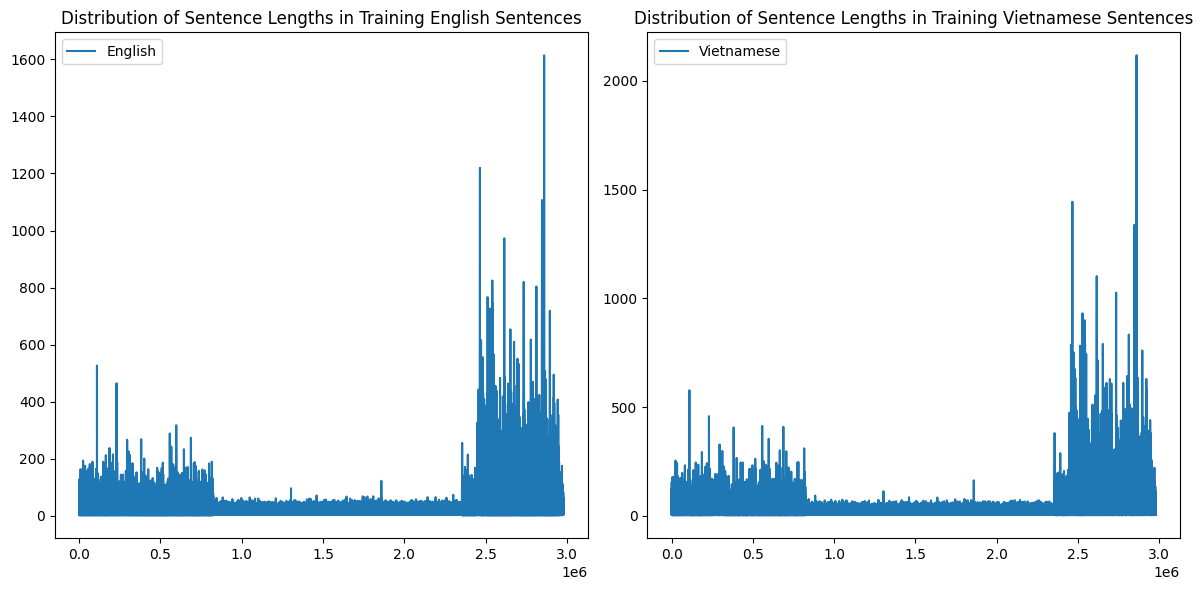

In [15]:
train_en_lens = [len(sentence) for sentence in train_en_sentences]
train_vi_lens = [len(sentence) for sentence in train_vi_sentences]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.plot(train_en_lens, label='English')
plt.title('Distribution of Sentence Lengths in Training English Sentences')
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(train_vi_lens, label='Vietnamese')
plt.title('Distribution of Sentence Lengths in Training Vietnamese Sentences')
plt.legend()

plt.tight_layout()
plt.show()

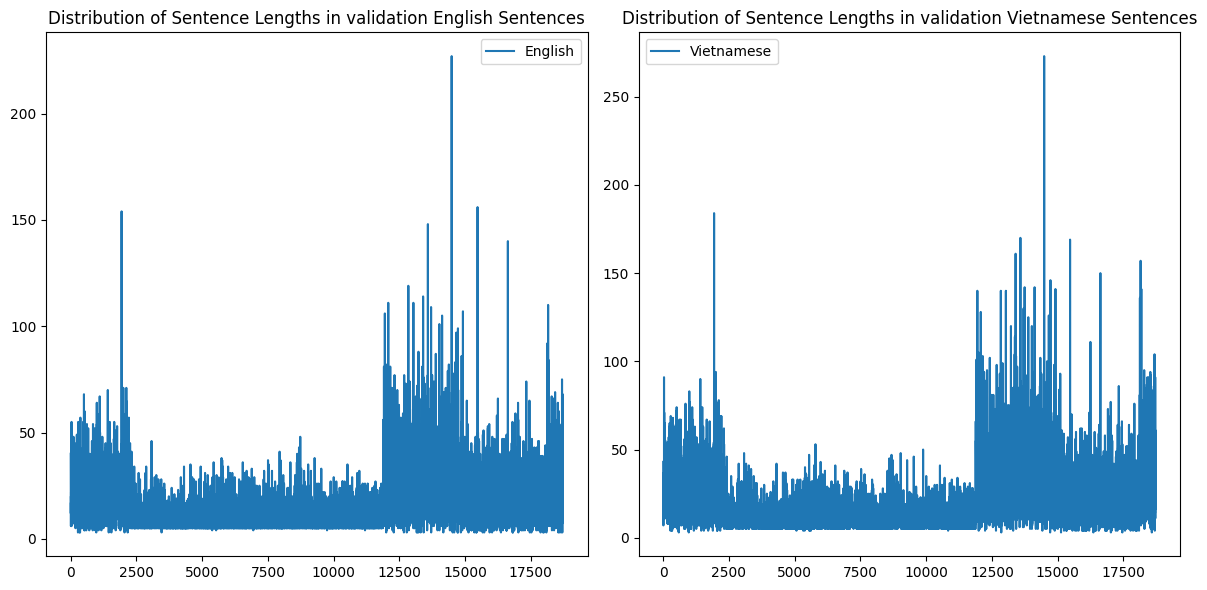

In [16]:
dev_en_lens = [len(sentence) for sentence in dev_en_sentences]
dev_vi_lens = [len(sentence) for sentence in dev_vi_sentences]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.plot(dev_en_lens, label='English')
plt.title('Distribution of Sentence Lengths in validation English Sentences')
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(dev_vi_lens, label='Vietnamese')
plt.title('Distribution of Sentence Lengths in validation Vietnamese Sentences')
plt.legend()

plt.tight_layout()
plt.show()

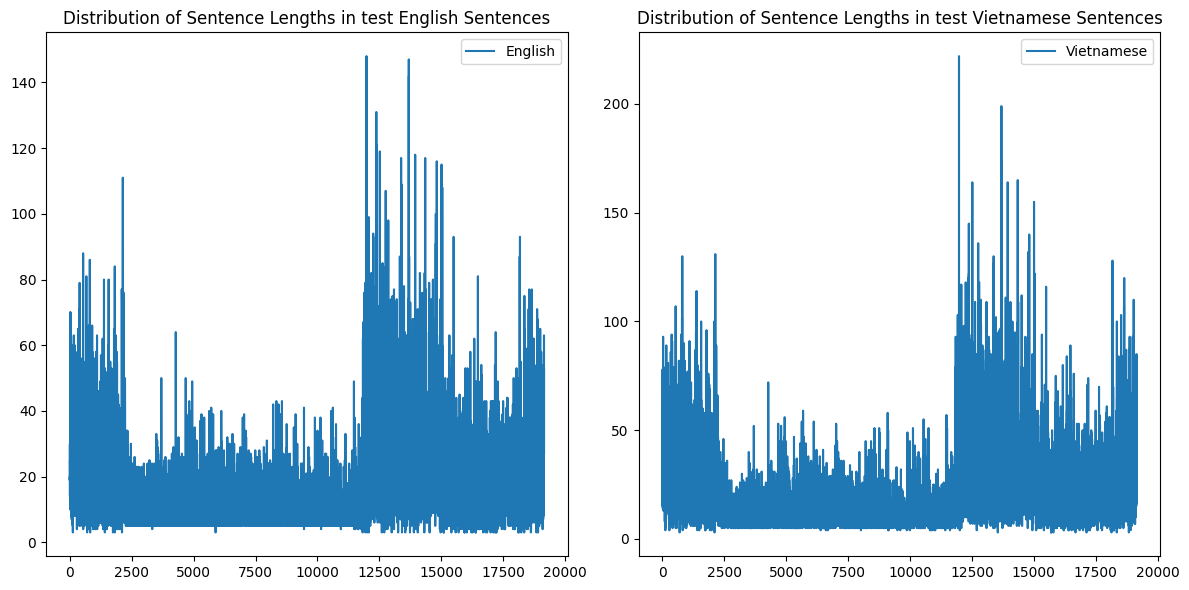

In [17]:
test_en_lens = [len(sentence) for sentence in test_en_sentences]
test_vi_lens = [len(sentence) for sentence in test_vi_sentences]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.plot(test_en_lens, label='English')
plt.title('Distribution of Sentence Lengths in test English Sentences')
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(test_vi_lens, label='Vietnamese')
plt.title('Distribution of Sentence Lengths in test Vietnamese Sentences')
plt.legend()

plt.tight_layout()
plt.show()